In [1]:
# CELL 0 This was for dbrepo DO NOT START WITH THIS
import getpass
import requests
from dbrepo.RestClient import RestClient

# 1) connect to DBRepo
username = "bbaltal"
password = getpass.getpass("Enter DBRepo password: ")
client = RestClient(
    endpoint="https://test.dbrepo.tuwien.ac.at",
    username=username,
    password=password
)

# 2) download each PID to local CSV
splits = {
    "regular_train.csv": "4421e56c-4cd3-4ec1-a566-a89d7ec0bced",
    "playoff_train.csv":  "bcb3cf2b-27df-48cc-8b76-9e49254783d0",
    "regular_test.csv": "f9d84d5e-db01-4475-b7d1-80cfe9fe0e61",
    "playoff_test.csv":  "de37d568-e97f-4cb9-bc05-2e600cc97102"
}
for fname, pid in splits.items():
    df = client.get_identifier_data(identifier_id=pid)
    df.to_csv(fname, index=False)
    print(f"Downloaded → {fname}")




Enter DBRepo password:  ········


Downloaded → regular_train.csv
Downloaded → playoff_train.csv
Downloaded → regular_test.csv
Downloaded → playoff_test.csv


In [1]:
# Cell-1 Reading the csv data
from pathlib import Path
import pandas as pd
import os
# compute project root (one level up from notebooks/)
project_root = Path().resolve().parent

# build path to processed data
processed_dir = project_root / "processed"

df_reg_tr = pd.read_csv(os.path.join(processed_dir, "regular_train.csv"))
df_reg_te = pd.read_csv(os.path.join(processed_dir, "regular_test.csv"))
df_plf_tr = pd.read_csv(os.path.join(processed_dir, "playoff_train.csv"))
df_plf_te = pd.read_csv(os.path.join(processed_dir, "playoff_test.csv"))

In [2]:
# Cell 2 ── Define your six core numeric targets
TARGETS = ["pts","reb","stl","tov","fg3a","fga"]

In [3]:
# Cell 3 ── Preprocess function (drops one TARGET, identifiers, encodes)
import pandas as pd

def preprocess(df_tr, df_te, TARGET):
    # split out the one target
    X_tr = df_tr.drop(columns=[TARGET])
    X_te = df_te.drop(columns=[TARGET])
    y_tr = df_tr[TARGET]
    y_te = df_te[TARGET]
    # drop identifiers/high-cardinality
    for c in ['regular_season_index','playoff_index','player_id','player','team_id','team']:
        X_tr = X_tr.drop(columns=[c], errors='ignore')
        X_te = X_te.drop(columns=[c], errors='ignore')
    # convert any remaining object cols to numeric
    for c in X_tr.select_dtypes(include=['object']).columns:
        X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')
        X_te[c] = pd.to_numeric(X_te[c], errors='coerce')
    # one-hot encode
    X_tr = pd.get_dummies(X_tr, drop_first=True)
    X_te = pd.get_dummies(X_te, drop_first=True).reindex(columns=X_tr.columns, fill_value=0)
    return X_tr, X_te, y_tr, y_te


In [4]:
import pandas as pd

# 0) load the CSVs you downloaded  from Cell 1
df_reg_tr = pd.read_csv(os.path.join(processed_dir, "regular_train.csv"))
df_reg_te = pd.read_csv(os.path.join(processed_dir, "regular_test.csv"))
df_plf_tr = pd.read_csv(os.path.join(processed_dir, "playoff_train.csv"))
df_plf_te = pd.read_csv(os.path.join(processed_dir, "playoff_test.csv"))

# 1) now call your preprocess() on each
X_reg_tr, X_reg_te, Y_reg_tr_pts, Y_reg_te_pts = preprocess(df_reg_tr, df_reg_te, TARGET=TARGETS[0])
X_plf_tr, X_plf_te, Y_plf_tr_pts, Y_plf_te_pts = preprocess(df_plf_tr, df_plf_te, TARGET=TARGETS[0])

print("X_reg_tr", X_reg_tr.shape, "X_reg_te", X_reg_te.shape)
print("X_plf_tr", X_plf_tr.shape, "X_plf_te", X_plf_te.shape)

X_reg_tr (5148, 25) X_reg_te (2145, 25)
X_plf_tr (539, 25) X_plf_te (214, 25)


In [5]:
# Cell 5 ── Build full multi-Y and drop all TARGET columns from X

# Whole regular-season multi-Y
Y_reg_tr = df_reg_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_reg_te = df_reg_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_reg_tr = X_reg_tr.drop(columns=[t], errors='ignore')
    X_reg_te = X_reg_te.drop(columns=[t], errors='ignore')

# Whole playoffs multi-Y
Y_plf_tr = df_plf_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_plf_te = df_plf_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_plf_tr = X_plf_tr.drop(columns=[t], errors='ignore')
    X_plf_te = X_plf_te.drop(columns=[t], errors='ignore')


In [6]:
# Cell 8 ── LAL team split (regular & playoffs)

# regular LAL 70/30 random
from sklearn.model_selection import train_test_split
df_LAL_r = pd.concat([df_reg_tr, df_reg_te]).query("team=='LAL'").reset_index(drop=True)
df_LAL_r_tr, df_LAL_r_te = train_test_split(df_LAL_r, test_size=0.3, random_state=42)

# playoffs LAL 70/30 random
df_LAL_p = pd.concat([df_plf_tr, df_plf_te]).query("team=='LAL'").reset_index(drop=True)
df_LAL_p_tr, df_LAL_p_te = train_test_split(df_LAL_p, test_size=0.3, random_state=42)

# preprocess & multi-Y
X_LAL_r_tr, X_LAL_r_te, _, _ = preprocess(df_LAL_r_tr, df_LAL_r_te, TARGET=TARGETS[0])
Y_LAL_r_tr = df_LAL_r_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_LAL_r_te = df_LAL_r_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_LAL_r_tr = X_LAL_r_tr.drop(columns=[t], errors='ignore')
    X_LAL_r_te = X_LAL_r_te.drop(columns=[t], errors='ignore')

X_LAL_p_tr, X_LAL_p_te, _, _ = preprocess(df_LAL_p_tr, df_LAL_p_te, TARGET=TARGETS[0])
Y_LAL_p_tr = df_LAL_p_tr[TARGETS].apply(pd.to_numeric, errors='coerce')
Y_LAL_p_te = df_LAL_p_te[TARGETS].apply(pd.to_numeric, errors='coerce')
for t in TARGETS:
    X_LAL_p_tr = X_LAL_p_tr.drop(columns=[t], errors='ignore')
    X_LAL_p_te = X_LAL_p_te.drop(columns=[t], errors='ignore')

print("Shapes (X_tr, Y_tr, X_te, Y_te):")
for name, (Xtr, Ytr, Xte, Yte) in [
    ("Reg-Whole", (X_reg_tr, Y_reg_tr, X_reg_te, Y_reg_te)),
    ("Plf-Whole", (X_plf_tr, Y_plf_tr, X_plf_te, Y_plf_te)),
    ("Reg-LAL",   (X_LAL_r_tr, Y_LAL_r_tr, X_LAL_r_te, Y_LAL_r_te)),
    ("Plf-LAL",   (X_LAL_p_tr, Y_LAL_p_tr, X_LAL_p_te, Y_LAL_p_te)),
]:
    print(f"{name:8s}", Xtr.shape, Ytr.shape, Xte.shape, Yte.shape)


Shapes (X_tr, Y_tr, X_te, Y_te):
Reg-Whole (5148, 20) (5148, 6) (2145, 20) (2145, 6)
Plf-Whole (539, 20) (539, 6) (214, 20) (214, 6)
Reg-LAL  (155, 20) (155, 6) (67, 20) (67, 6)
Plf-LAL  (18, 20) (18, 6) (9, 20) (9, 6)


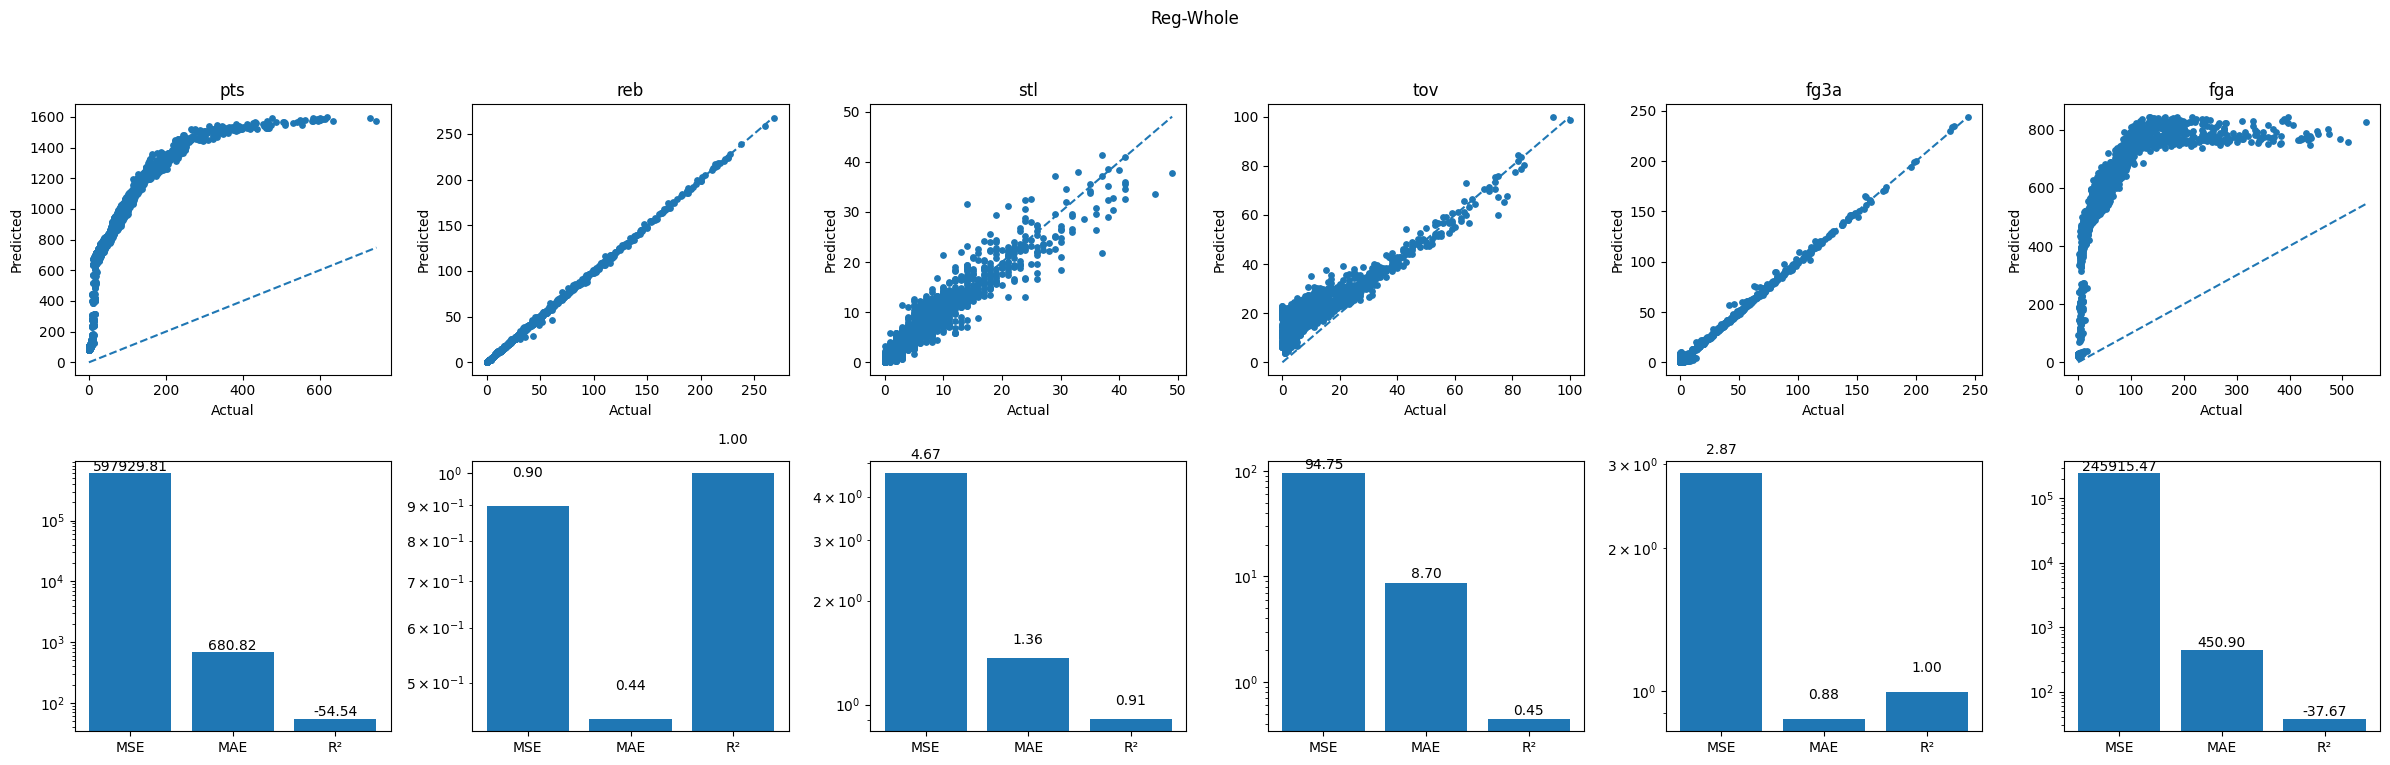

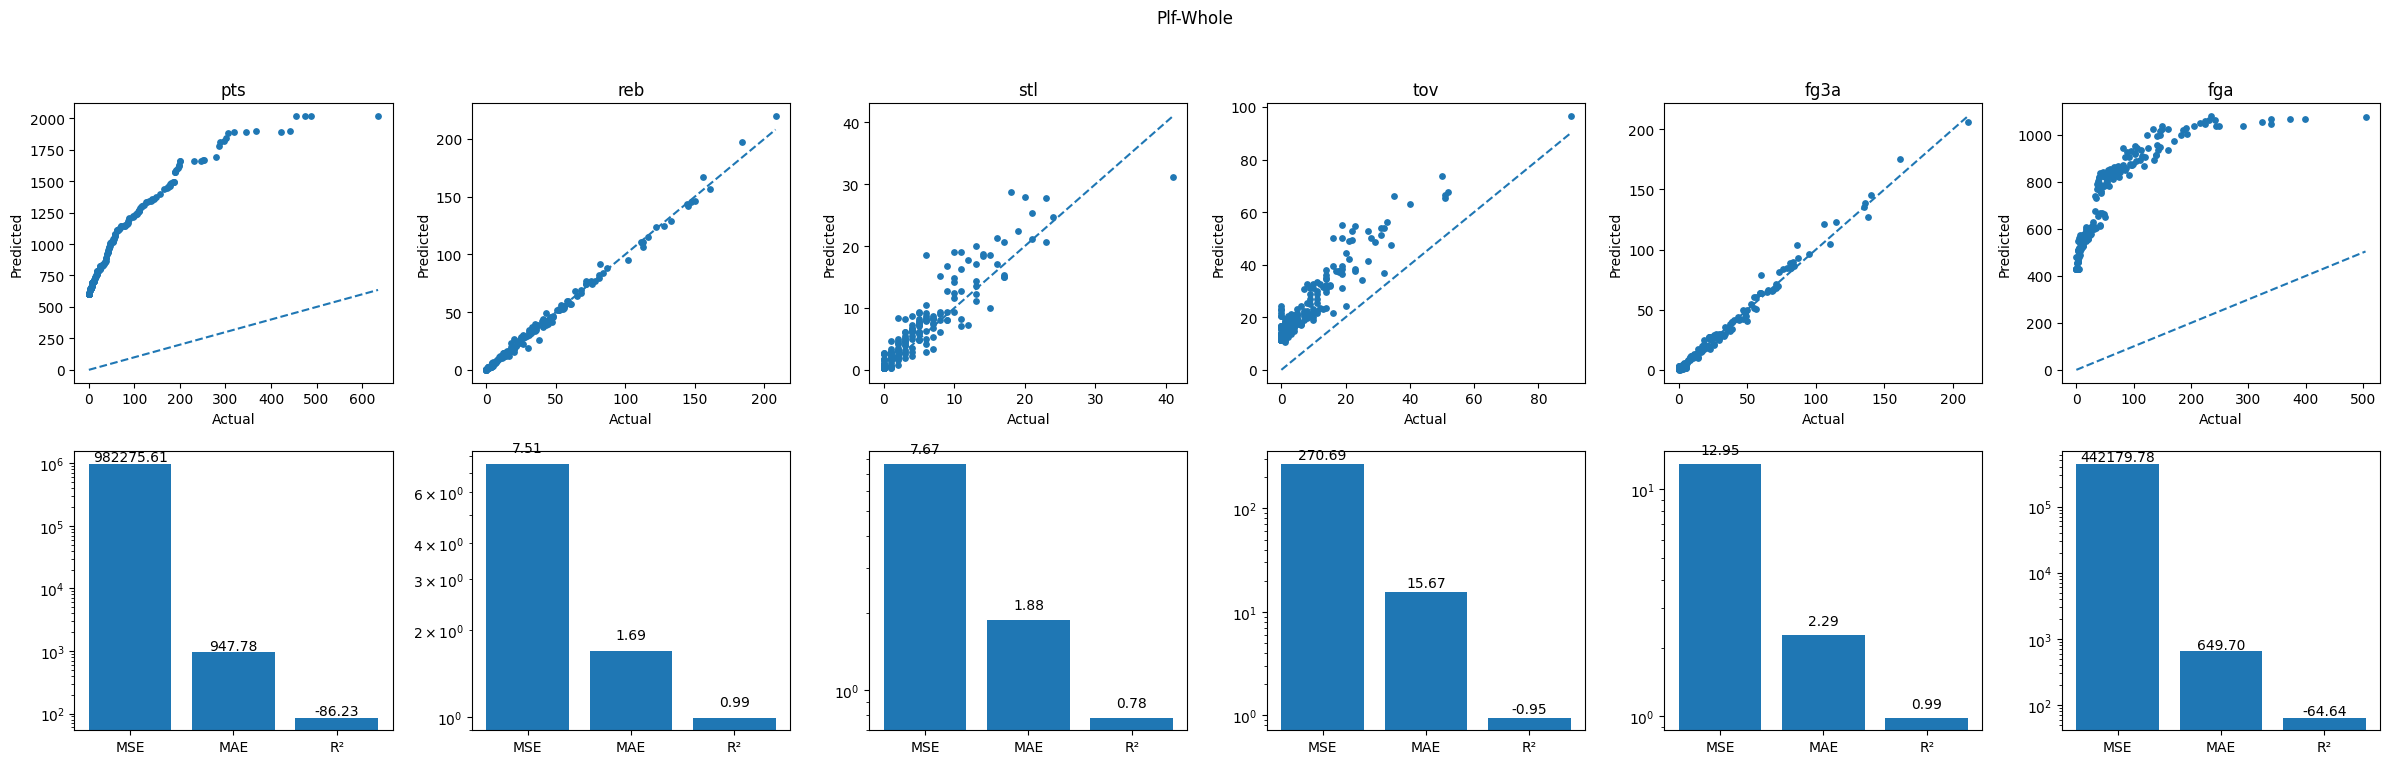

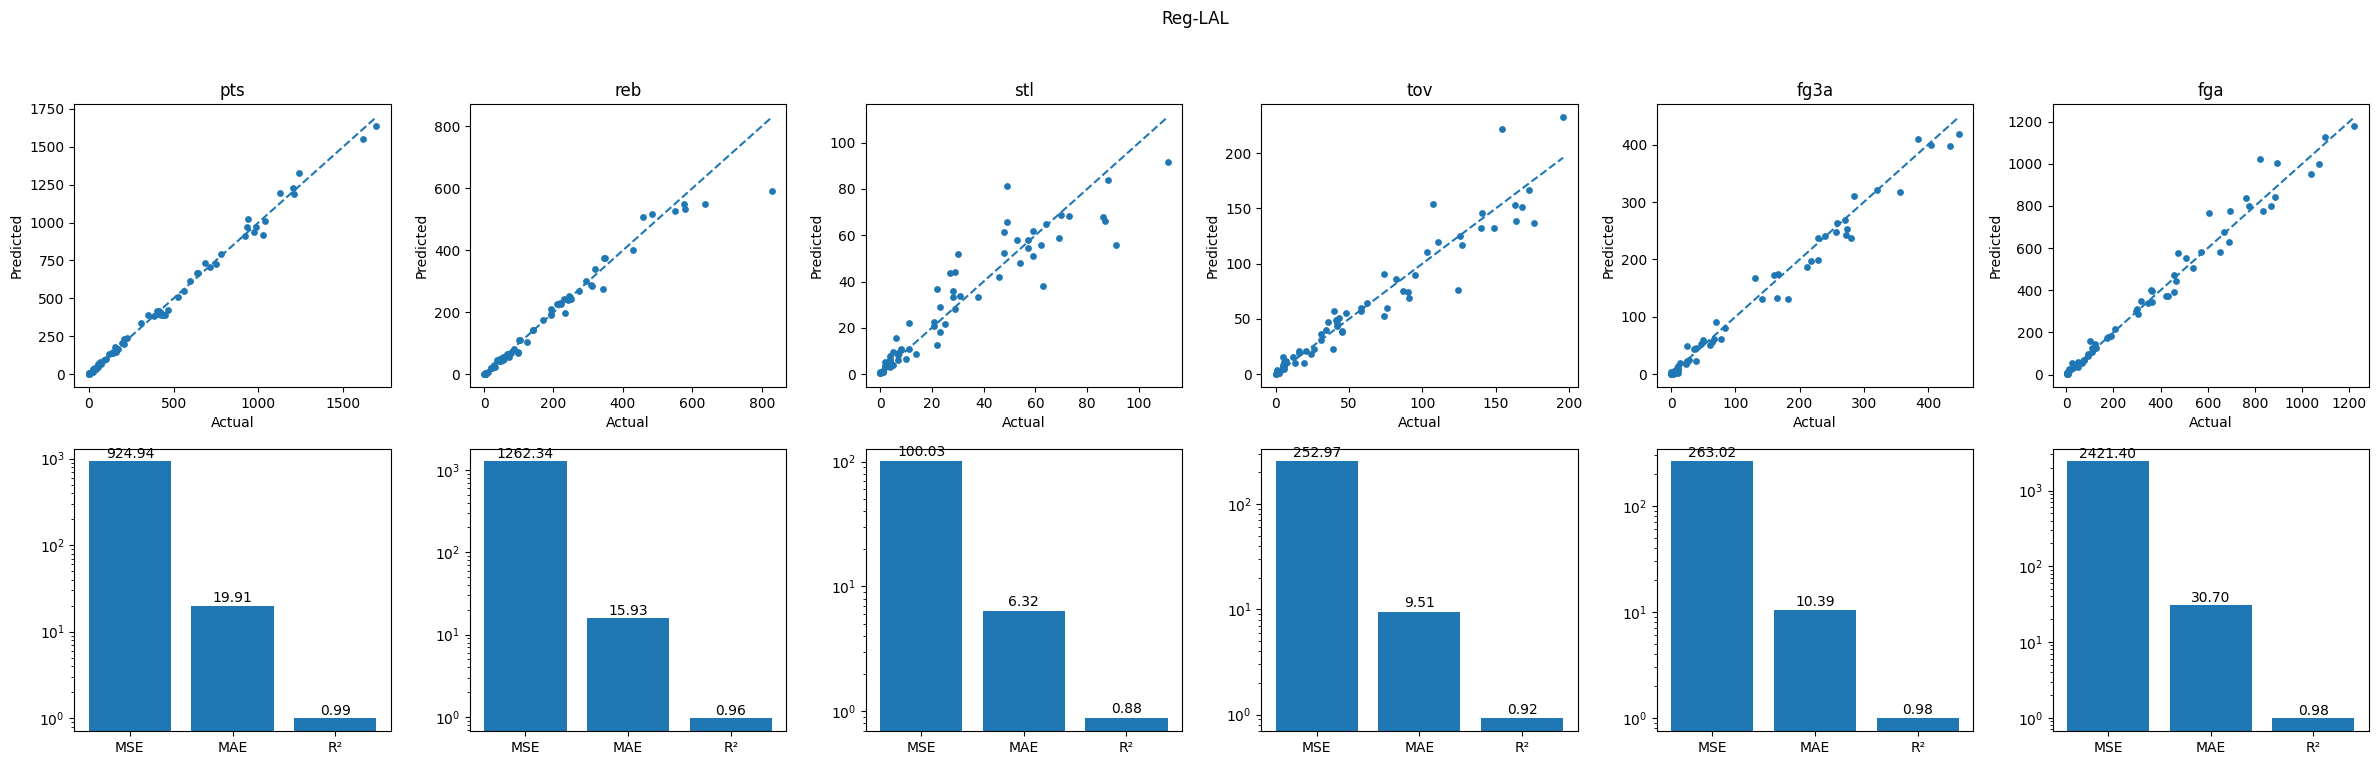

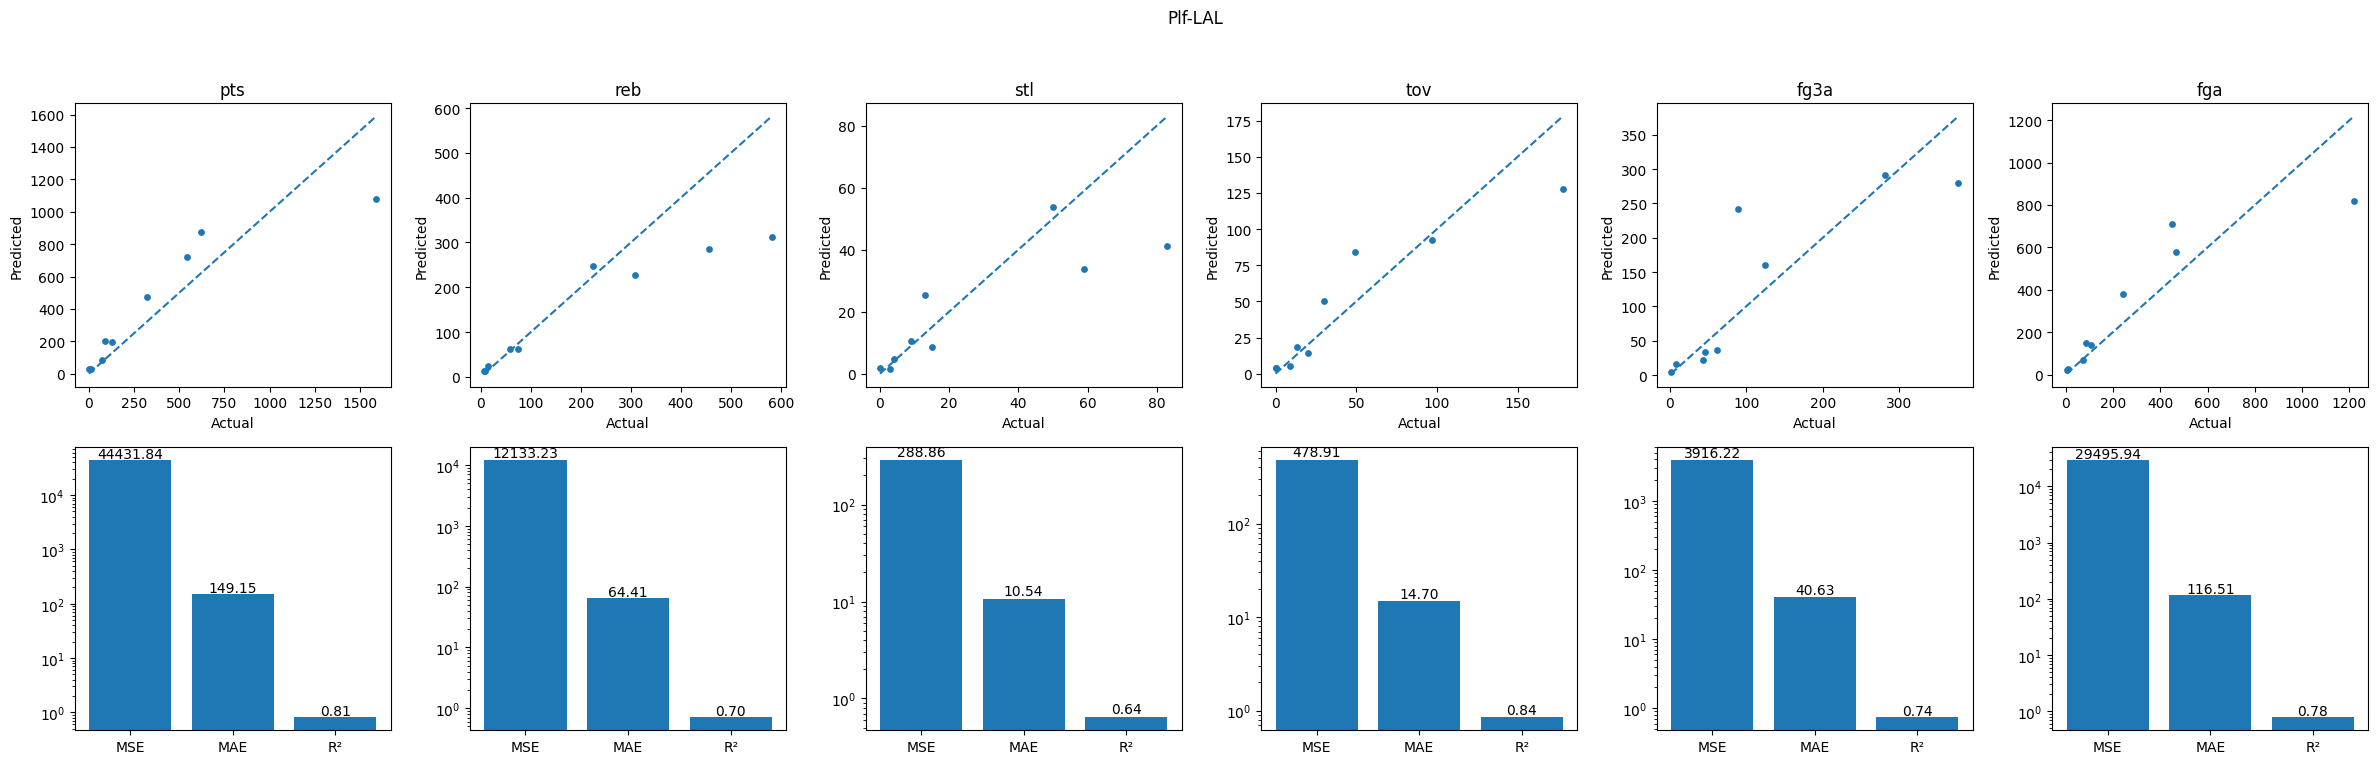

                 MAE                                                           \
Stat            fg3a         fga         pts        reb        stl        tov   
Scenario                                                                        
Plf-LAL    40.632222  116.510000  149.147778  64.412222  10.538889  14.696667   
Plf-Whole   2.288505  649.697103  947.783738   1.689579   1.884626  15.672570   
Reg-LAL    10.390448   30.702090   19.914925  15.928358   6.322985   9.510149   
Reg-Whole   0.875274  450.904120  680.817953   0.443408   1.359520   8.698237   

                 R²                                                      
Stat           fg3a        fga        pts       reb       stl       tov  
Scenario                                                                 
Plf-LAL    0.736449   0.779868   0.807360  0.703269  0.638002  0.843946  
Plf-Whole  0.988650 -64.640755 -86.233810  0.994945  0.783666 -0.946914  
Reg-LAL    0.984303   0.978229   0.994966  0.961746  0.876785 

In [7]:
# Cell 3 ── Define your six core numeric targets and scenario list (no R10)
TARGETS = ["pts","reb","stl","tov","fg3a","fga"]

# scenarios ← only Whole and LAL, for Regular and Playoffs
scenarios = [
    ("Reg-Whole", df_reg_tr, df_reg_te),
    ("Plf-Whole", df_plf_tr, df_plf_te),
    ("Reg-LAL", *train_test_split(pd.concat([df_reg_tr, df_reg_te])
                                   .query("team=='LAL'"),
                                  test_size=0.3, random_state=42)),
    ("Plf-LAL", *train_test_split(pd.concat([df_plf_tr, df_plf_te])
                                   .query("team=='LAL'"),
                                  test_size=0.3, random_state=42)),
]

# Cell 4 ── Preprocess function
import pandas as pd

def preprocess(df_tr, df_te, TARGET):
    X_tr = df_tr.drop(columns=[TARGET])
    X_te = df_te.drop(columns=[TARGET])
    y_tr = df_tr[TARGET]
    y_te = df_te[TARGET]
    for c in ['regular_season_index','playoff_index','player_id','player','team_id','team']:
        X_tr = X_tr.drop(columns=[c], errors='ignore')
        X_te = X_te.drop(columns=[c], errors='ignore')
    for c in X_tr.select_dtypes(include=['object']).columns:
        X_tr[c] = pd.to_numeric(X_tr[c], errors='coerce')
        X_te[c] = pd.to_numeric(X_te[c], errors='coerce')
    X_tr = pd.get_dummies(X_tr, drop_first=True)
    X_te = pd.get_dummies(X_te, drop_first=True).reindex(columns=X_tr.columns, fill_value=0)
    return X_tr, X_te, y_tr, y_te

# Cell 5 ── Build feature / multi-Y matrices for each scenario
from sklearn.multioutput import MultiOutputRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt

results = []
for name, dtr, dte in scenarios:
    # preprocess all TARGETS at once
    # start by doing pts then drop all TARGET columns from X
    X_tr, X_te, _, _ = preprocess(dtr, dte, TARGET=TARGETS[0])
    for t in TARGETS:
        X_tr = X_tr.drop(columns=[t], errors='ignore')
        X_te = X_te.drop(columns=[t], errors='ignore')
    Y_tr = dtr[TARGETS].apply(pd.to_numeric, errors='coerce')
    Y_te = dte[TARGETS].apply(pd.to_numeric, errors='coerce')

    # train & predict multi-output
    m = MultiOutputRegressor(RandomForestRegressor(n_estimators=100, random_state=42))
    m.fit(X_tr, Y_tr)
    Y_pr = m.predict(X_te)

    # evaluate & plot
    n = len(TARGETS)
    fig, axes = plt.subplots(2, n, figsize=(4*n, 8))
    fig.suptitle(name)
    for i, stat in enumerate(TARGETS):
        y_true = Y_te[stat].to_numpy()
        y_hat  = Y_pr[:, i]

        # scatter
        ax = axes[0, i]
        ax.scatter(y_true, y_hat, s=15)
        mn, mx = y_true.min(), y_true.max()
        ax.plot([mn,mx],[mn,mx],"--")
        ax.set_title(stat)
        ax.set_xlabel("Actual"); ax.set_ylabel("Predicted")

        # metrics bar
        mse = mean_squared_error(y_true, y_hat)
        mae = mean_absolute_error(y_true, y_hat)
        r2  = r2_score(y_true, y_hat)
        ax2 = axes[1, i]
        ax2.bar(["MSE","MAE","R²"], [mse, mae, abs(r2)])
        ax2.set_yscale("log")
        for j, v in enumerate([mse, mae, r2]):
            ax2.text(j, abs(v)*1.1, f"{v:.2f}", ha='center')

        results.append({"Scenario":name, "Stat":stat, "MAE":mae, "R²":r2})

    plt.tight_layout(rect=[0,0.03,1,0.95])
    plt.show()

# summary table
import pandas as pd
df_res = pd.DataFrame(results)
print(df_res.pivot(index="Scenario", columns="Stat", values=["MAE","R²"]))
